<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/MarkovChains_local_aer_NewQiskit_20240409.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
######################################################
# 코드의 목적: 마르코프체인 행렬을 양자회로를 이용해 계산하는 방법
# 작성자: 박문기(mkbahk@gmail.com)
# 최초작성일: 20230926
# 마지막수정일: 20240308
# 수정사유: Qiskit 1.0.2 Update 반영
######################################################

In [41]:
!python3 -m pip install qiskit[visualization]
!python3 -m pip install qiskit-ionq
!python3 -m pip install qiskit-ibm-provider
!python3 -m pip install qiskit-aer

In [49]:
import numpy as np

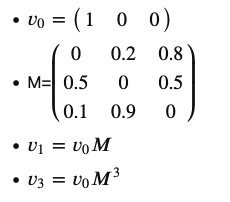

In [62]:
import numpy as np
M = np.array([[0, 0.2, 0.8], [0.5, 0, 0.5], [0.1, 0.9, 0]])
v0=np.array([1,0,0])
v1=v0.dot(M)
print(v1)
v2=v0.dot(np.linalg.matrix_power(M, 2))
print(v2)
v3=v0.dot(np.linalg.matrix_power(M, 3))
print(v3)

[0.  0.2 0.8]
[0.18 0.72 0.1 ]
[0.37  0.126 0.504]


In [82]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from numpy import pi

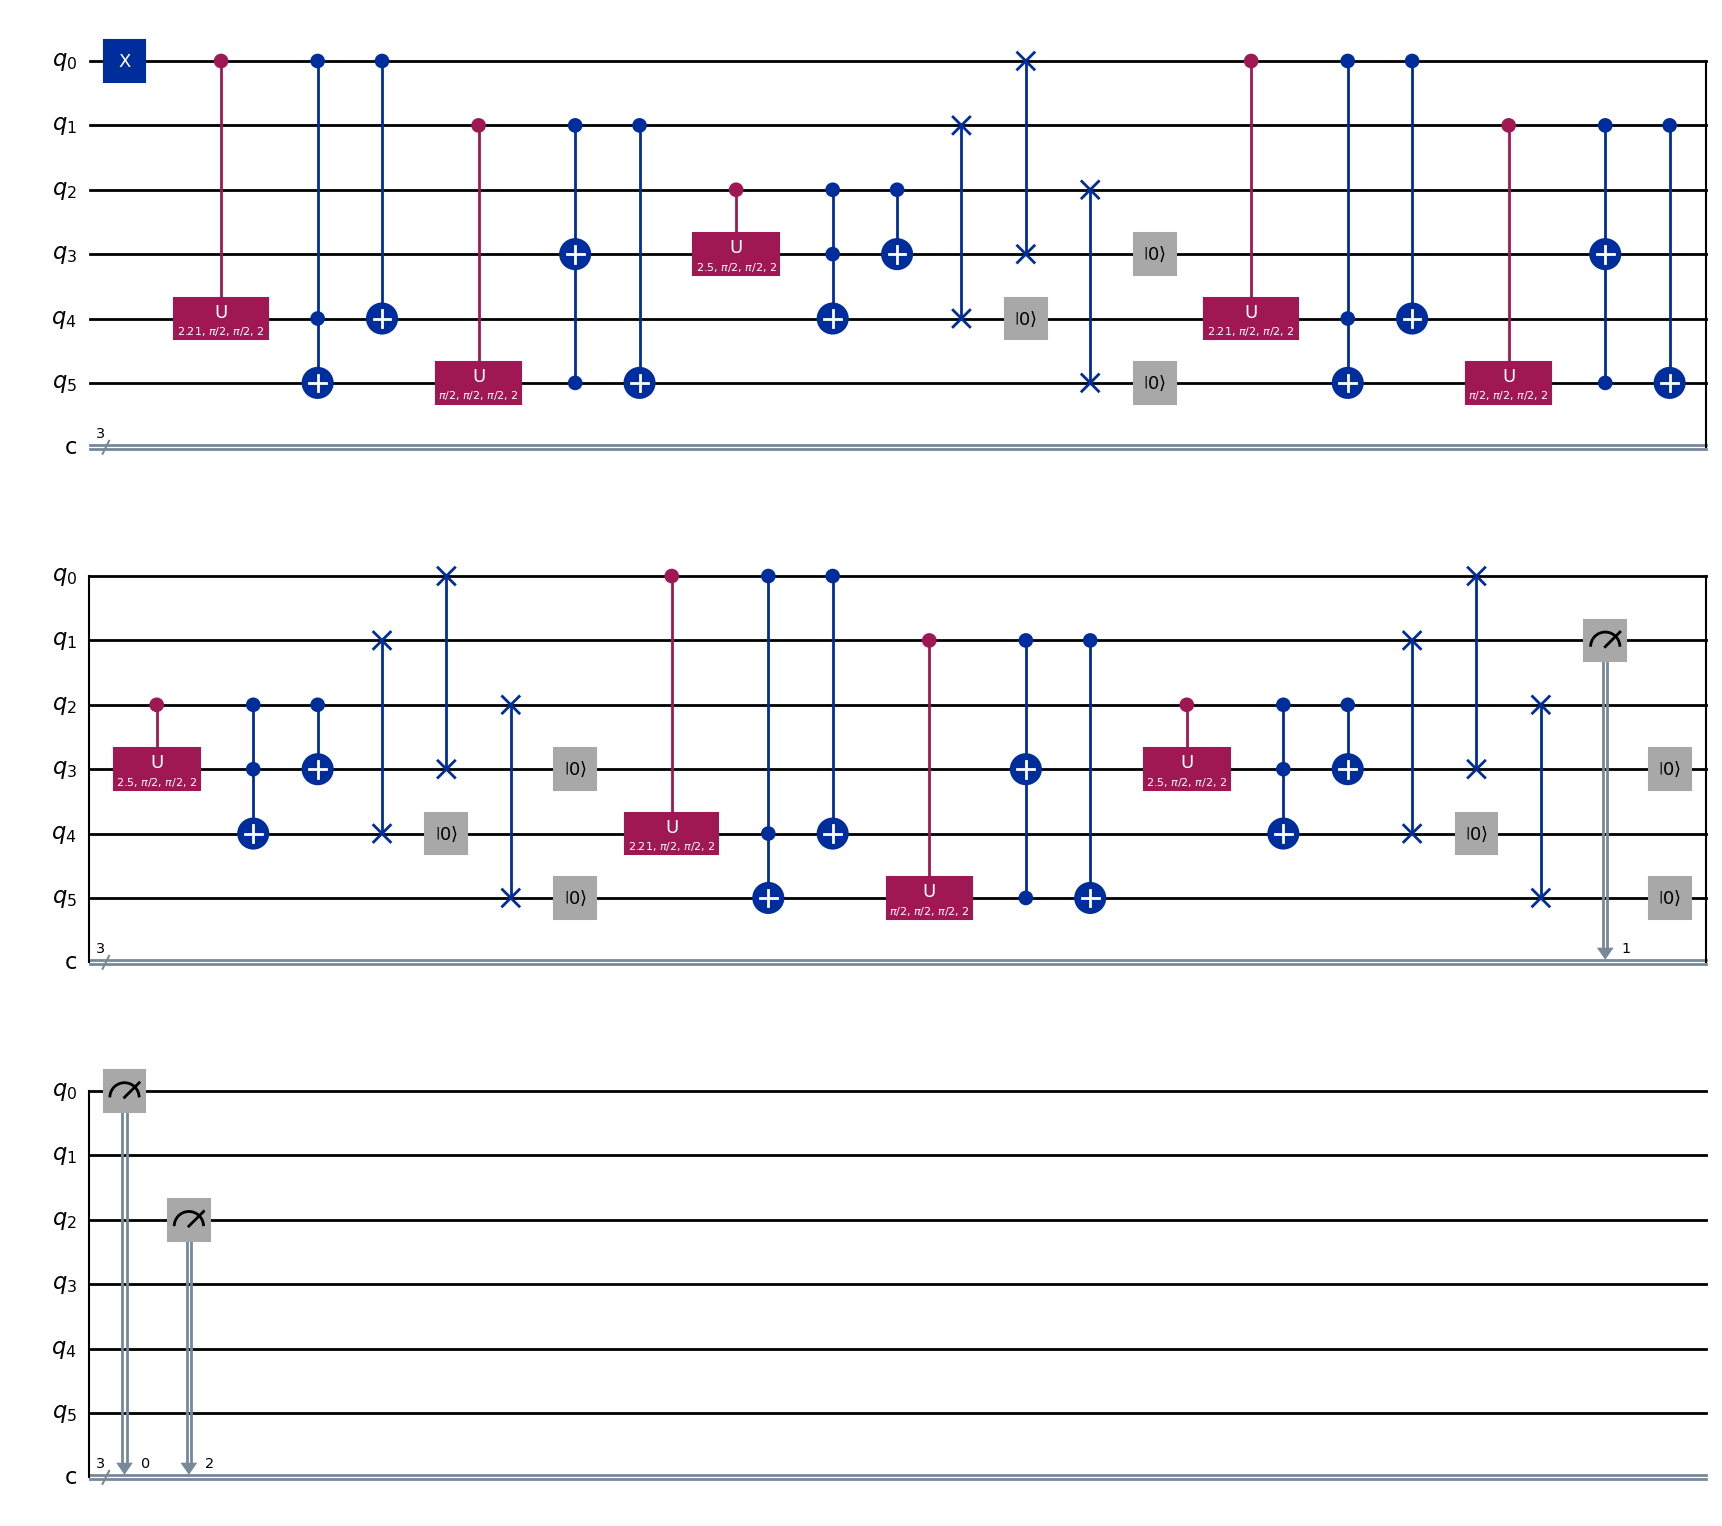

In [99]:
# Inilialise registers
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(3, 'c')

# Create Markov Step as a circuit
markov_step = QuantumCircuit(qreg_q)

# Create the Markov Step
# From state 0 to state 1 and 2
markov_step.cu(2*np.arccos(np.sqrt(M[0,1])), pi/2, pi/2, _ , qreg_q[0], qreg_q[4])
markov_step.ccx(qreg_q[4], qreg_q[0], qreg_q[5])
markov_step.cx(qreg_q[0], qreg_q[4])

# From state 1 to state 0 and 2
markov_step.cu(2*np.arccos(np.sqrt(M[1,2])), pi/2, pi/2, _ , qreg_q[1], qreg_q[5])
markov_step.ccx(qreg_q[5], qreg_q[1], qreg_q[3])
markov_step.cx(qreg_q[1], qreg_q[5])

# From state 2 to state 0 and 1
markov_step.cu(2*np.arccos(np.sqrt(M[2,0])), pi/2, pi/2,  _ , qreg_q[2], qreg_q[3])
markov_step.ccx(qreg_q[3], qreg_q[2], qreg_q[4])
markov_step.cx(qreg_q[2], qreg_q[3])

# Swap
markov_step.swap(qreg_q[0], qreg_q[3])
markov_step.swap(qreg_q[1], qreg_q[4])
markov_step.swap(qreg_q[2], qreg_q[5])

# Initialise circuit
qc = QuantumCircuit(qreg_q,creg_c)

# Initialise state (1,0,0)
qc.x(0)

# Do the markov step n times
n = 3
for _ in range(n):
    for ins in markov_step:
        qc.append(ins[0], ins[1], ins[2])
    qc.reset(qreg_q[3:])

# Measure outcome
qc.measure(qreg_q[:3], creg_c)
qc.draw('mpl')

In [100]:
# Qiskit Local Simulator 사용하기 위한 준비
from qiskit_aer import Aer

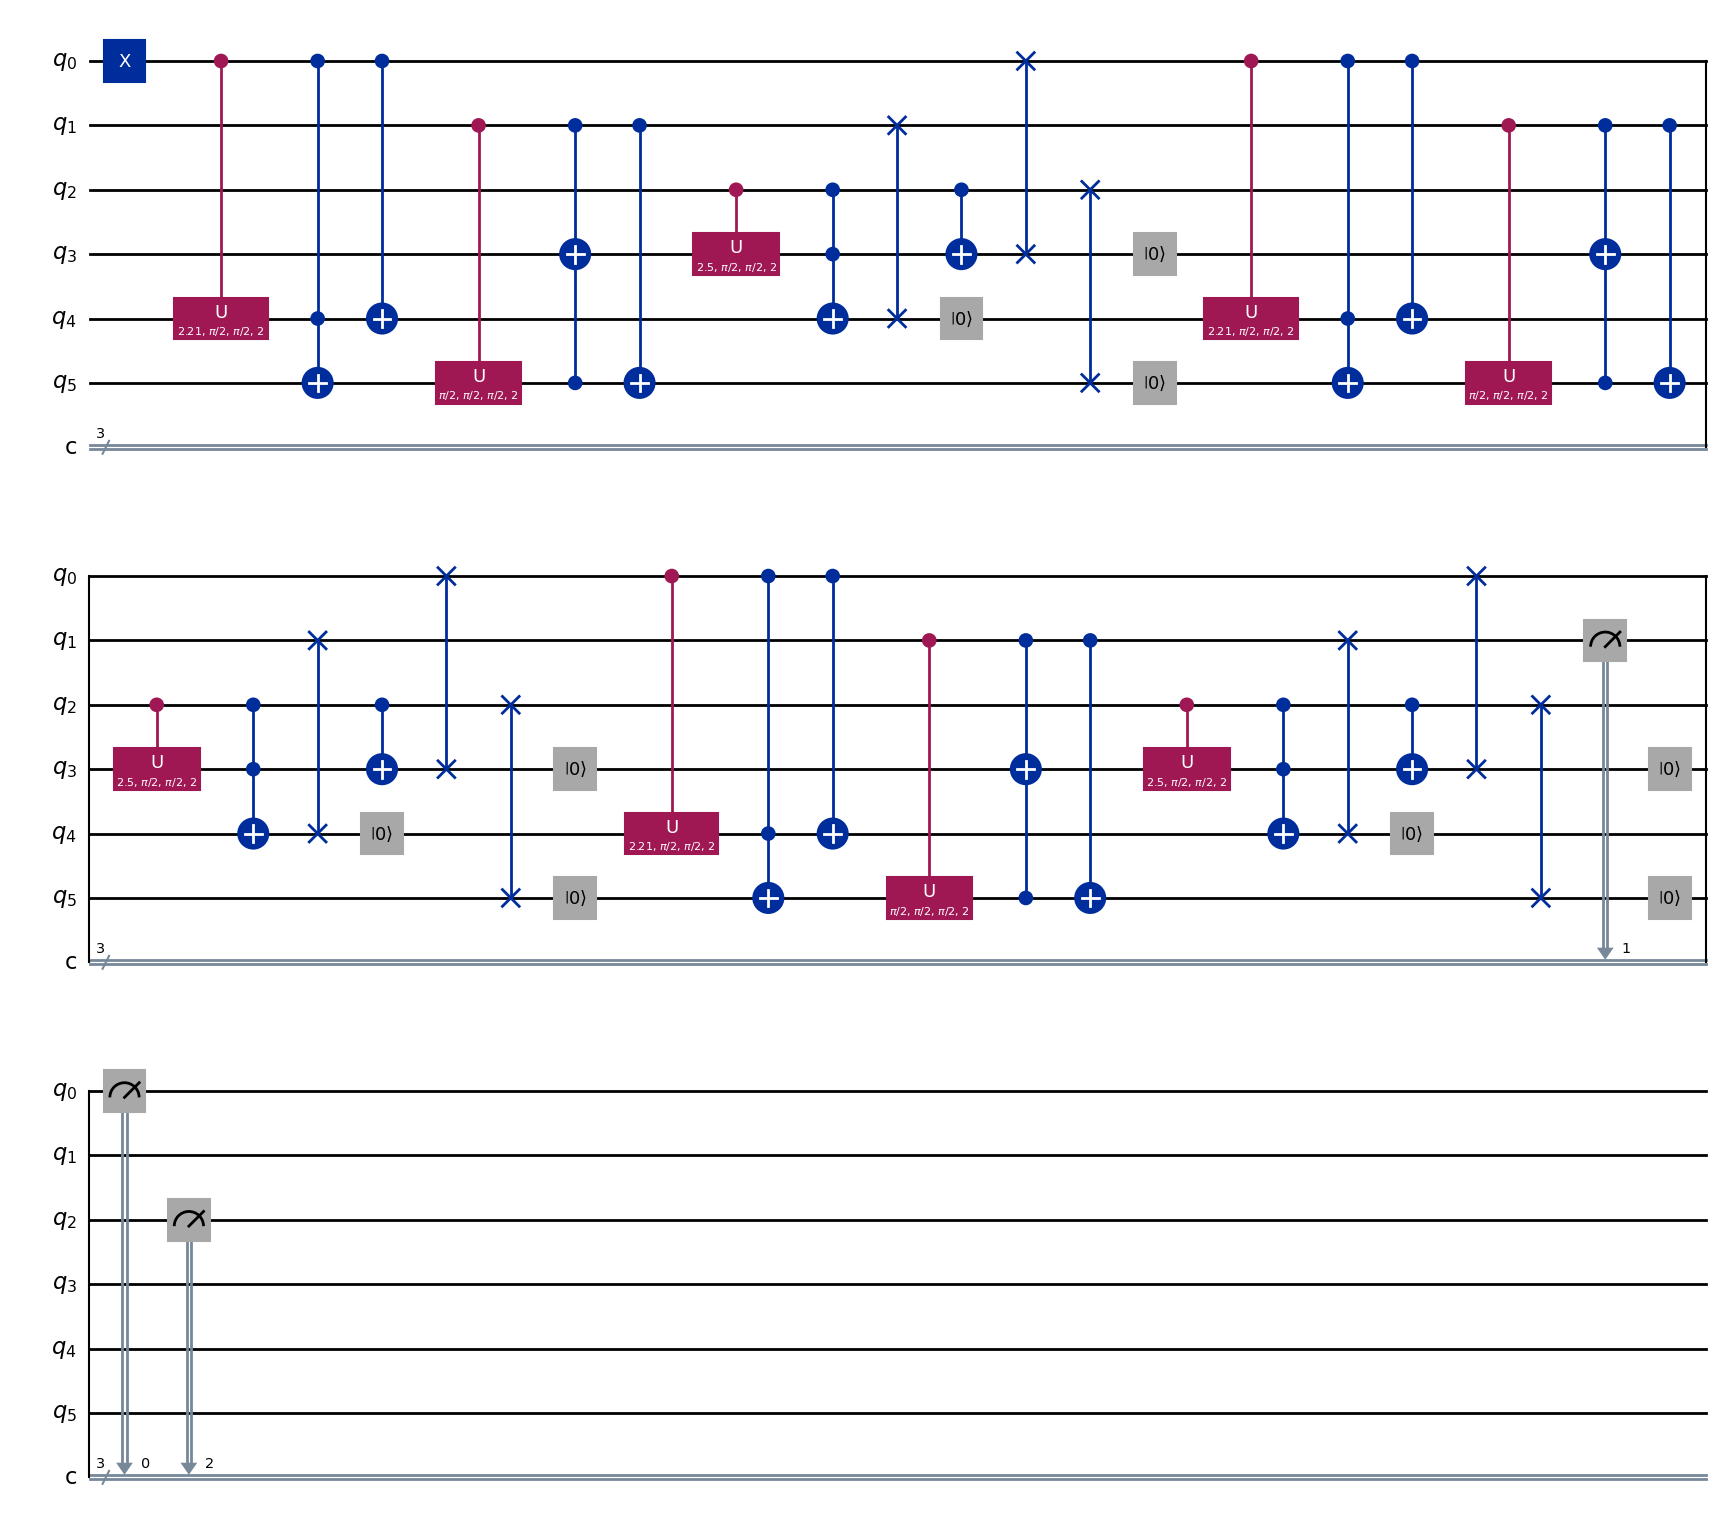

In [101]:
#여러 장치들에게 선택적으로 수행시키기 위한 준비
from qiskit.compiler import transpile, assemble
#
#백엔드들을 이용한 실제 장치나 시뮬레이터를 이용한 실행
#
#backend = ionq_provider.get_backend('ionq_simulator')
#backend = ionq_provider.get_backend('ionq_qpu')
#backend = ionq_provider.get_backend('qpu.aria-1')
#backend = ibm_provider.get_backend('ibmq_qasm_simulator') # Cloud상 시뮬레이터
#backend = ibm_provider.get_backend('ibm_brisbane')
backend = Aer.get_backend('qasm_simulator')  #Local Qiskit Aer 시뮬레이터 사용

#양자컴 하드웨어마다 지원할 수 있는 Gate의 종류가 달라서, 일반GATE를 각 하드웨어 지원 Gate로 변환하는 과정을 Transpile이라 한다.
trans_qc = transpile(qc, backend)
trans_qc.draw('mpl')

In [102]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)
#job = backend.run(qc, shots=2048) # if you don’t pass a shots kwarg, it defaults to 1024

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 실행 상태 확인
while job.status() is not JobStatus.DONE:
	print("Job status is", job.status() )
	time.sleep(2)
###while

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", job.status() )

# 결과 출력
counts = job.result().get_counts()
print(counts)

Job ID is 26be4de0-5337-4f3f-b77c-1d8a2e0a8940 

Job status is JobStatus.RUNNING
Job status is JobStatus.DONE
{'001': 403, '010': 132, '100': 489}


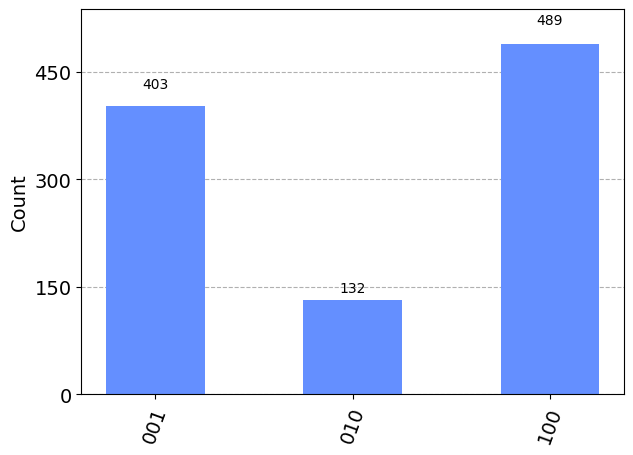

In [103]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [ ]:
import qiskit.utils
qiskit.utils.local_hardware_info()

{'python_compiler': 'GCC 11.4.0',
 'python_build': 'main, Nov 20 2023 15:14:05',
 'python_version': '3.10.12',
 'os': 'Linux',
 'cpus': 1}